In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from glob import glob
import os

In [2]:
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import vgg16, InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [3]:
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [4]:
# IRO TFA CCFE

In [5]:
IMAGE_SIZE = [224, 224]

In [6]:
vgg19 = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

In [7]:
# dont train the existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('geological_similarity/*')
folders

['geological_similarity\\andesite',
 'geological_similarity\\gneiss',
 'geological_similarity\\marble',
 'geological_similarity\\quartzite',
 'geological_similarity\\rhyolite',
 'geological_similarity\\schist']

In [9]:
# Converting images to dataframe to process it
def data_prep(andesite, gneiss, marble, quartzite, rhyolite, schist):

    andesite = ["geological_similarity/andesite" + '/' +  a for a in andesite]
    gneiss = ["geological_similarity/gneiss" + '/' +  b for b in gneiss]
    marble = ["geological_similarity/marble" + '/' +  c for c in marble]
    quartzite = ["geological_similarity/quartzite" + '/' +  d for d in quartzite]
    rhyolite = ["geological_similarity/rhyolite" + '/' +  e for e in rhyolite]
    schist = ["geological_similarity/schist" + '/' +  f for f in schist]

    labels = len(andesite)*['andesite'] + len(gneiss)*['gneiss'] + len(marble)*['marble'] + len(quartzite)*['quartzite'] + len(rhyolite)*['rhyolite'] + len(schist)*['schist']
    data = andesite + gneiss + marble + quartzite + rhyolite + schist

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir('geological_similarity/andesite/'), os.listdir('geological_similarity/gneiss/'), os.listdir('geological_similarity/marble/'), os.listdir('geological_similarity/quartzite/'), os.listdir('geological_similarity/rhyolite/'), os.listdir('geological_similarity/schist/'))
df

,Image_Path,Labels
0,geological_similarity/andesite/012L6.jpg,andesite
1,geological_similarity/andesite/01ITR.jpg,andesite
2,geological_similarity/andesite/01LQQ.jpg,andesite
3,geological_similarity/andesite/0230P.jpg,andesite
4,geological_similarity/andesite/02741.jpg,andesite
...,...,...
29993,geological_similarity/schist/ZYMEE.jpg,schist
29994,geological_similarity/schist/ZYRT4.jpg,schist
29995,geological_similarity/schist/ZZ4TJ.jpg,schist
29996,geological_similarity/schist/ZZ5Z5.jpg,schist


Text(0.5, 1.0, 'Distribution of samples according to the categories')

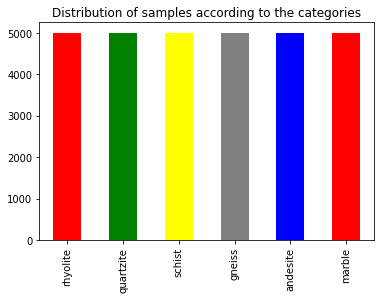

In [10]:
df['Labels'].value_counts().plot(kind = 'bar', color = ['red', 'green', 'yellow', 'grey', 'blue'])
plt.title('Distribution of samples according to the categories')

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=1)

In [12]:
test.shape

(6000, 2)

In [13]:
# Time for data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
x_train =  train_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='categorical',target_size=(224,224), shuffle=False, batch_size=10, seed=10)
x_test = test_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='categorical',  target_size=(224,224), shuffle=False, batch_size=10, seed=10)
len(x_train), len(x_test)

Found 23998 validated image filenames belonging to 6 classes.
Found 6000 validated image filenames belonging to 6 classes.


(2400, 600)

In [15]:
# Lets make the CNN for this
# Create CNN

import tensorflow as tf
model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(6, activation='sigmoid')
  ])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model_history = model.fit_generator(generator = x_train, 
                   steps_per_epoch = 100,
                   epochs = 5 ,
                   validation_data = x_test,
                   validation_steps = 100)


C:\Users\rohan\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 23s 151ms/step - loss: 1.4076 - accuracy: 0.3910 - val_loss: 0.8969 - val_accuracy: 0.5500
Epoch 2/5
100/100 [==============================] - 12s 115ms/step - loss: 0.8097 - accuracy: 0.6620 - val_loss: 0.6831 - val_accuracy: 0.7090
Epoch 3/5
100/100 [==============================] - 12s 115ms/step - loss: 0.6029 - accuracy: 0.7640 - val_loss: 0.3105 - val_accuracy: 0.8910
Epoch 4/5
100/100 [==============================] - 11s 112ms/step - loss: 0.6574 - accuracy: 0.7570 - val_loss: 0.6868 - val_accuracy: 0.7440
Epoch 5/5
100/100 [==============================] - 11s 109ms/step - loss: 0.5617 - accuracy: 0.8000 - val_loss: 0.3757 - val_accuracy: 0.8490


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        1

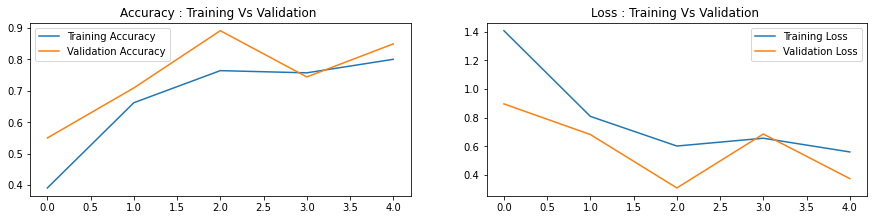

In [19]:

accuracy = model_history.history['accuracy']
loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']
validation_accuracy = model_history.history['val_accuracy']



plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(len(accuracy)), loss, label='Training Loss')
plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()


In [20]:
# Image embedding
# def get_embedding(file, model):
#     image = mpimg.imread(file)
#     image = test_transform(image)
#     image = image.unsqueeze(0)
#     model.eval()
#     with torch.no_grad():
#         emb, _ = model(image)
#     return emb.numpy()

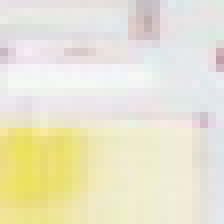

In [58]:
from tensorflow.keras.preprocessing import image
img=image.load_img('../Geological Similarity Amazon/geological_similarity/gneiss/01KD2.jpg',target_size=(224,224))
img2=image.load_img('../Geological Similarity Amazon/geological_similarity/andesite/6KGKG.jpg',target_size=(224,224))
img

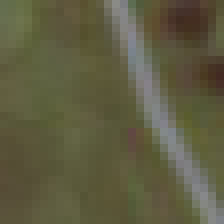

In [59]:
img2

In [61]:
images = np.zeros(shape=(1, 224, 224, 3))
images2 = np.zeros(shape=(1, 224, 224, 3))
x_raw = image.img_to_array(img)
x_raw2 = image.img_to_array(img2)
x_raw.shape, x_raw2.shape

((224, 224, 3), (224, 224, 3))

In [ ]:
def img_matching(img):
    for i in img_files:
        x_raw_file = image.img_to_array(img)
        x_raw_file_compare = image.img_to_array(i)
        x_expand_file = np.expand_dims(x_raw_file, axis=0)
        x_expand_file_compare = np.expand_dims(x_raw_file_compare, axis=0)
        images[0, :, :, :] = x_expand_file
        images_compare[0, :, :, :] = x_expand_file_compare
        inputs = preprocess_input(images)
        inputs_compare = preprocess_input(images_compare)
        images_features = model.predict(inputs)
        images_features_chosen = model.predict(inputs_compare)
        
        similarities = cosine_similarity(images_features, images_features_chosen)
    similarities

In [51]:
#overwrite first instance of images placeholder with the image array
x_expand = np.expand_dims(x_raw, axis=0)
x_expand2 = np.expand_dims(x_raw2, axis=0)
images[0, :, :, :] = x_expand
images2[0, :, :, :] = x_expand2

# preprocess your image to be able to enter the neural network
inputs = preprocess_input(images)
inputs2 = preprocess_input(images2)
inputs.shape, inputs2.shape

((1, 224, 224, 3), (1, 224, 224, 3))

In [52]:

#predict image features
images_features = model.predict(inputs)
images_features2 = model.predict(inputs2)
vector = images_features[0]
vector2 = images_features2[0]
print(vector.shape, vector2.shape)
# (4096,)
# print(vector)
# [0.        0.        0.        ... 0.        1.9249601 0.8309637]

(6,) (6,)


In [53]:
images_features, images_features2

(array([[0., 1., 0., 0., 0., 1.]], dtype=float32),
 array([[1., 0., 1., 0., 1., 1.]], dtype=float32))

In [65]:
similarities = cosine_similarity(images_features, images_features2)
similarities[0][0]*100

35.35533845424652

In [55]:
# Initial files are in r'input\raw' directory
root_dir = '../Geological Similarity Amazon/geological_similarity'

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
print('dataset length = ', len(img_files))
print('First 5 files:', img_files[0:1])

dataset length =  29999
First 5 files: ['../Geological Similarity Amazon/geological_similarity\\.DS_Store']


In [27]:
# Select random test images
# Select random image from test
random_file = random.choice(img_files)

# Get the embedding for this image
emb = get_embedding(random_file, model=model)

print(random_file)
plt.rcParams["figure.figsize"] = (3,3)
image = mpimg.imread(random_file)
plt.imshow(image)
plt.show()

NameError: name 'get_embedding' is not defined

In [ ]:
# Calculate the image embeddings
%%time
image_embeddings = np.zeros((len(img_files), 128))
for idx, file in enumerate(img_files):
    image_embeddings[idx] = get_embedding(file, model=model)
print(image_embeddings.shape)

In [ ]:
# Preview K most similar images to the selected one
similarities = cosine_similarity(emb, image_embeddings)
# Select top n-similar file indeces
K=5
ids = np.flip(similarities.argsort()[0])[0:K]

for index in ids:
    image = img_files[index]
    print(image)
    image = mpimg.imread(image)
    plt.imshow(image)
    plt.show()

In [ ]:
model.summary()

In [ ]:
# Building VGG19
def vgg19_model(df, train, test):
    x_train =  train_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = test_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)
    model=Sequential()
    model.add(vgg19_model)
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    model_history = model.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100, 
    epochs = 4)
    
    return model_history
    
plot_loss_and_accuracy(vgg19_model(df, train, test))